<a href="https://colab.research.google.com/github/c-e-leiva/AprendizajeAutomatico2/blob/main/TP3_Postas_desafio_imagenes_parte_2_(sugerencias).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SUGERENCIAS APLICADAS DEL TP3**
__________________________

### **⚙️ Configuración del entorno: Activación de GPU**

Para acelerar el entrenamiento del modelo, se habilitó el uso de GPU en el entorno de ejecución. Esto permite procesar grandes volúmenes de datos de forma mucho más eficiente, especialmente útil en tareas de aprendizaje profundo.

#### ✅ Cómo activar la GPU en Google Colab:

1. Ir al menú superior: `Entorno de ejecución` → `Cambiar tipo de entorno de ejecución`.
2. En el apartado `Acelerador de hardware`, seleccionar `GPU`.
3. Presionar `Guardar`.

Una vez hecho esto, se puede verificar si la GPU está activa y detectar su nombre con el siguiente código en PyTorch:


In [ ]:
import torch
print("✅ GPU activa:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "❌ GPU no disponible")

✅ GPU activa: Tesla T4


## ⚠️ **Nota:** Esta sección incluye sugerencias aplicadas al trabajo original realizado por Nolberto en la Parte 1.
Se realizaron ajustes y mejoras con fines de aprendizaje y optimización del modelo.  
> 🧪 Estas modificaciones fueron implementadas con el objetivo de mejorar el entrenamiento, aunque lo ideal sería verificar cuidadosamente cada cambio para confirmar si efectivamente aporta beneficios al rendimiento.  

> 🤝 El enfoque fue aprovechar el trabajo existente como base para seguir aprendiendo y explorando nuevas formas de mejorar.

# **Parte 1: Clasificador de Perros y Gatos con CNN**

-1.1 Descargue y descomprima el dataset.

-1.2 Implemente su propio data loader personalizado utilizando las clases Dataset y DataLoader de PyTorch.

-1.2.1 Incluya transformaciones apropiadas para las imágenes (redimensionamiento, normalización, data augmentation, etc.)

-1.2.2 Divida los datos en conjuntos de entrenamiento, validación y prueba (sugerencia: 70%, 15%, 15%).

-1.3 Realice una exploración inicial de los datos (distribución de clases, dimensiones de las imágenes, etc.).

## **📦 1.1 Descargue y descomprima el dataset**

Este código se encarga de descargar el dataset "Cats vs Dogs" desde una URL oficial y descomprimirlo en una carpeta local para poder usarlo en el entrenamiento.

- Primero verifica si el archivo ZIP ya fue descargado para no descargarlo nuevamente y ahorrar tiempo y espacio.
- Luego, si la carpeta con las imágenes no existe, descomprime el archivo ZIP para preparar los datos.
- La descarga se realiza por bloques para evitar errores por conexión y mejorar la estabilidad.
- Todo esto automatiza la preparación del dataset, evitando tener que hacerlo manualmente y asegurando que los datos estén listos para el preprocesamiento y entrenamiento.

In [ ]:
import os
import zipfile
import requests
from pathlib import Path

# URL del dataset Cats vs Dogs (Microsoft/Kaggle)
dataset_url = "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip"

# Ruta local donde se guardará el archivo ZIP descargado
zip_path = Path("kagglecatsanddogs_5340.zip")

# Carpeta donde se extraerán las imágenes del dataset
extract_dir = Path("PetImages")

def download_dataset(url: str, dest: Path):
    """
    Descarga el archivo ZIP del dataset desde la URL especificada,
    solo si no existe localmente para evitar duplicados.
    """
    if dest.exists():
        print(f"✅ Archivo '{dest}' ya existe. No se descarga.")
        return

    print(f"⬇️ Descargando dataset desde {url} ...")

    # Solicitud HTTP con streaming para descargar por bloques
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Lanza excepción si ocurre un error en la descarga

    # Guardar el archivo en modo binario, escribiendo chunk por chunk
    # (un chunk es un bloque de datos, en este caso de 8192 bytes = 8 KB)
    with open(dest, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:  # Evita escribir chunks vacíos
                f.write(chunk)

    print("✅ Descarga completada.")

def unzip_dataset(zip_file: Path, extract_to: Path):
    """
    Descomprime el archivo ZIP en la carpeta destino,
    solo si la carpeta no existe para evitar repetir la operación.
    """
    if extract_to.exists():
        print(f"✅ Carpeta '{extract_to}' ya existe. No se descomprime.")
        return

    print(f"📦 Descomprimiendo {zip_file} ...")

    # Abre el ZIP y extrae todo su contenido en el directorio actual
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()

    print("✅ Descompresión completada.")

# Ejecutamos la descarga y descompresión del dataset
download_dataset(dataset_url, zip_path)
unzip_dataset(zip_path, extract_dir)

✅ Archivo 'kagglecatsanddogs_5340.zip' ya existe. No se descarga.
✅ Carpeta 'PetImages' ya existe. No se descomprime.


## **🧾 1.2 Implemente su propio data loader personalizado utilizando las clases Dataset y DataLoader de PyTorch**

En esta sección se implementa un data loader personalizado utilizando las clases Dataset y DataLoader de PyTorch, como indica la consigna.

Primero, se define la clase CatsDogsDataset que extiende torch.utils.data.Dataset. Esta clase gestiona la carga de imágenes de gatos y perros a partir de un listado de rutas, asociándolas con sus etiquetas binarias (0 para gatos, 1 para perros), y permite aplicar transformaciones opcionales, como el redimensionamiento y la conversión a tensor, para preparar las imágenes para el entrenamiento.

Luego, el código recorre las carpetas de cada clase para obtener todas las rutas de imágenes disponibles. Para asegurar la calidad del dataset, se realiza un filtrado de imágenes corruptas o inválidas, específicamente aquellas que no pueden abrirse correctamente o que no están en formato RGB, evitando así errores durante el entrenamiento.

Finalmente, se crea una instancia del dataset con las imágenes validadas y las transformaciones aplicadas, y se utiliza un DataLoader para iterar sobre los datos en batches (lotes) de tamaño configurable, con mezcla aleatoria (shuffle). Esto facilita el entrenamiento de modelos al procesar los datos de manera eficiente y escalable.

In [ ]:
import os
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset personalizado para gatos y perros
class CatsDogsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths            # Lista de rutas a imágenes
        self.labels = labels                      # Lista de etiquetas: 0 (gato), 1 (perro)
        self.transform = transform                # Transformaciones a aplicar (opcional)

    def __len__(self):
        return len(self.image_paths)              # Devuelve la cantidad total de muestras

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]          # Ruta de la imagen
        label = self.labels[idx]                  # Etiqueta correspondiente
        image = Image.open(img_path).convert("RGB")  # Abrir imagen y convertir a RGB
        if self.transform:
            image = self.transform(image)         # Aplicar transformaciones si están definidas
        return image, label

# Transformaciones de preprocesamiento: redimensionar y convertir a tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Cambiar tamaño a 128x128 píxeles
    transforms.ToTensor(),          # Convertir imagen PIL a tensor
])

# Directorio base del dataset
base_dir = "PetImages"

# Recorremos las carpetas de gatos y perros para obtener rutas y etiquetas
image_paths = []
labels = []

for label_name, label in [("Cat", 0), ("Dog", 1)]:
    folder = os.path.join(base_dir, label_name)
    for img_file in os.listdir(folder):
        if img_file.lower().endswith((".jpg")):  # ✅ Filtrar por extensión
            full_path = os.path.join(folder, img_file)
            image_paths.append(full_path)
            labels.append(label)

# Filtrar imágenes corruptas para evitar errores al abrirlas
valid_image_paths = []
valid_labels = []
corrupt_images = []

for img_path, label in zip(image_paths, labels):
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verifica si la imagen está completa
        with Image.open(img_path) as img_check:
            if img_check.mode != 'RGB':
                raise ValueError("Imagen no está en modo RGB")
        valid_image_paths.append(img_path)
        valid_labels.append(label)
    except (IOError, SyntaxError, ValueError) as e:
        corrupt_images.append(img_path)

# Mostrar resumen de imágenes corruptas
print(f"⚠️ Se encontraron [ {len(corrupt_images)} ] imágenes corruptas o inválidas:")
for img in corrupt_images:
    print(f"  ❌ {img}")

print(f"\n✅ Total de imágenes válidas: {len(valid_image_paths)}")
print(f"🔢 Total de imágenes encontradas inicialmente: {len(image_paths)}\n")

# Crear el dataset personalizado con las imágenes válidas y transformaciones
dataset = CatsDogsDataset(image_paths=valid_image_paths, labels=valid_labels, transform=transform)
'''
# Crear el DataLoader con batch size de 32 y mezcla aleatoria (shuffle)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Probar el DataLoader: mostrar forma de un batch
for images, labels in data_loader:
    print(f"Imágenes: {images.shape}, Etiquetas: {labels}")
    break  # Solo mostramos el primer batch
'''

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


⚠️ Se encontraron [ 69 ] imágenes corruptas o inválidas:
  ❌ PetImages/Cat/660.jpg
  ❌ PetImages/Cat/7276.jpg
  ❌ PetImages/Cat/2663.jpg
  ❌ PetImages/Cat/140.jpg
  ❌ PetImages/Cat/3300.jpg
  ❌ PetImages/Cat/5686.jpg
  ❌ PetImages/Cat/11095.jpg
  ❌ PetImages/Cat/11874.jpg
  ❌ PetImages/Cat/3491.jpg
  ❌ PetImages/Cat/9778.jpg
  ❌ PetImages/Cat/2939.jpg
  ❌ PetImages/Cat/10501.jpg
  ❌ PetImages/Cat/850.jpg
  ❌ PetImages/Cat/11565.jpg
  ❌ PetImages/Cat/7978.jpg
  ❌ PetImages/Cat/12080.jpg
  ❌ PetImages/Cat/5553.jpg
  ❌ PetImages/Cat/936.jpg
  ❌ PetImages/Cat/8470.jpg
  ❌ PetImages/Cat/10125.jpg
  ❌ PetImages/Cat/10820.jpg
  ❌ PetImages/Cat/5370.jpg
  ❌ PetImages/Cat/666.jpg
  ❌ PetImages/Cat/11210.jpg
  ❌ PetImages/Cat/11935.jpg
  ❌ PetImages/Cat/4833.jpg
  ❌ PetImages/Cat/6435.jpg
  ❌ PetImages/Cat/7968.jpg
  ❌ PetImages/Cat/9171.jpg
  ❌ PetImages/Cat/9565.jpg
  ❌ PetImages/Dog/6718.jpg
  ❌ PetImages/Dog/5736.jpg
  ❌ PetImages/Dog/8730.jpg
  ❌ PetImages/Dog/10401.jpg
  ❌ PetImages/Dog/71

'\n# Crear el DataLoader con batch size de 32 y mezcla aleatoria (shuffle)\ndata_loader = DataLoader(dataset, batch_size=32, shuffle=True)\n\n# Probar el DataLoader: mostrar forma de un batch\nfor images, labels in data_loader:\n    print(f"Imágenes: {images.shape}, Etiquetas: {labels}")\n    break  # Solo mostramos el primer batch\n'

## **1.2.1 Transformaciones aplicadas a las imágenes (resize, normalización y data augmentation)**

Para preparar las imágenes para el entrenamiento del modelo, es fundamental aplicar transformaciones que incluyan:

Resize: Redimensionar todas las imágenes a un tamaño estándar (por ejemplo, 128x128 píxeles) para que el modelo reciba entradas homogéneas.

Normalización: Ajustar los valores de píxel para que tengan una media y desviación estándar específicas (normalmente la media y desviación de ImageNet), lo que ayuda a estabilizar y acelerar el entrenamiento.

Data augmentation (aumento de datos): Aplicar transformaciones aleatorias (como rotaciones, volteos horizontales, recortes, cambios de brillo) para que el modelo aprenda a generalizar mejor y no se sobreajuste.

Usaremos torchvision.transforms para crear un pipeline de transformaciones que se aplicarán a cada imagen durante la carga.

In [ ]:
from torchvision import transforms

# Definimos las transformaciones para el conjunto de entrenamiento
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),            # Redimensionar imágenes a 128x128
    transforms.RandomHorizontalFlip(),        # Data augmentation: volteo horizontal aleatorio
    transforms.RandomRotation(15),             # Data augmentation: rotación aleatoria hasta 15 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Ajuste aleatorio de brillo, contraste y saturación
    transforms.ToTensor(),                     # Convertir imagen PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización con valores típicos de ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Transformaciones para validación y test (solo resize y normalización, sin augmentations)
val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Ejemplo de cómo aplicar estas transformaciones en el dataset personalizado
# dataset_train = CatsDogsDataset(image_paths=train_image_paths, labels=train_labels, transform=train_transforms)
# dataset_val = CatsDogsDataset(image_paths=val_image_paths, labels=val_labels, transform=val_test_transforms)

## 🧪 1.2.2 Divida los datos en conjuntos de entrenamiento, validación y prueba
Dividimos las imágenes válidas en 70% entrenamiento, 15% validación y 15% prueba. Antes filtramos imágenes corruptas. Se usa `train_test_split` de `sklearn` y `stratify` para conservar la distribución de clases.


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import random
import numpy as np

# --- Función para fijar semilla ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Fijamos semilla general

# Dividimos en 3 conjuntos: train (70%), validation (15%), test (15%)

# 1) Primero dividimos en train (70%) y temp (30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    valid_image_paths,
    valid_labels,
    test_size=0.30,
    random_state=42,
    stratify=valid_labels  # Para conservar la proporción en los splits
)

# 2) Ahora dividimos temp (30%) en validation (15%) y test (15%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

# Mostrar resumen de tamaños
print(f"Tamaño train: {len(train_paths)}")
print(f"Tamaño validation: {len(val_paths)}")
print(f"Tamaño test: {len(test_paths)}")

# Creamos datasets
dataset_train = CatsDogsDataset(image_paths=train_paths, labels=train_labels, transform=train_transforms)
dataset_val = CatsDogsDataset(image_paths=val_paths, labels=val_labels, transform=val_test_transforms)
dataset_test = CatsDogsDataset(image_paths=test_paths, labels=test_labels, transform=val_test_transforms)

# Creamos generador con semilla para reproducibilidad en shuffle
generator = torch.Generator()
generator.manual_seed(42)

# DataLoaders con generador en el train_loader para que el shuffle sea reproducible
train_loader = DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    generator=generator
)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# --- Función para fijar semilla ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Fijamos semilla general

# Dividimos en 3 conjuntos: train (70%), validation (15%), test (15%)

# 1) Primero dividimos en train (70%) y temp (30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    valid_image_paths,
    valid_labels,
    test_size=0.30,
    random_state=42,
    stratify=valid_labels  # Para conservar la proporción de gatos y perros en ambos sets
)

# 2) Ahora dividimos temp (30%) en validation (15%) y test (15%)
# Como temp es 30%, dividirlo a la mitad nos da 15% y 15%
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

# Mostrar resumen de tamaños
print(f"Tamaño train: {len(train_paths)}")
print(f"Tamaño validation: {len(val_paths)}")
print(f"Tamaño test: {len(test_paths)}")

# Ahora ya podés crear datasets y dataloaders separados con sus respectivas transformaciones:

dataset_train = CatsDogsDataset(image_paths=train_paths, labels=train_labels, transform=train_transforms)
dataset_val = CatsDogsDataset(image_paths=val_paths, labels=val_labels, transform=val_test_transforms)
dataset_test = CatsDogsDataset(image_paths=test_paths, labels=test_labels, transform=val_test_transforms)

# Creamos generador con semilla para reproducibilidad en shuffle
generator = torch.Generator()
generator.manual_seed(42)

# DataLoaders con generador en el train_loader para que el shuffle sea reproducible
train_loader = DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    generator=generator)

# Ejemplo: DataLoader para entrenamiento
#train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Tamaño train: 17451
Tamaño validation: 3740
Tamaño test: 3740
Tamaño train: 17451
Tamaño validation: 3740
Tamaño test: 3740


## **🔍 1.3 Realice una exploración inicial de los datos**
Esta función realiza una exploración completa del dataset dividido en conjuntos de entrenamiento, validación y prueba. Imprime la cantidad total de imágenes válidas, la distribución de clases (gatos y perros) en cada subconjunto, y las dimensiones promedio, mínima y máxima de las imágenes en todo el dataset. Esto permite entender la composición y características básicas del dataset antes de entrenar un modelo.

In [ ]:
from collections import Counter
import numpy as np
from PIL import Image

def print_dataset_summary(train_paths, train_labels, val_paths, val_labels, test_paths, test_labels):
    # Mapeo de etiquetas numéricas a nombres legibles
    label_names = {0: "Cat", 1: "Dog"}

    # Función auxiliar para contar gatos y perros en una lista de etiquetas
    def counts(labels):
        c = Counter(labels)
        return c.get(0, 0), c.get(1, 0)

    # Contar gatos y perros en cada subconjunto
    train_cats, train_dogs = counts(train_labels)
    val_cats, val_dogs = counts(val_labels)
    test_cats, test_dogs = counts(test_labels)

    # Totales generales
    total_cats = train_cats + val_cats + test_cats
    total_dogs = train_dogs + val_dogs + test_dogs
    total_all = total_cats + total_dogs

    # Imprimir cantidad total de imágenes válidas
    print(f"Total imágenes válidas:       {total_all}\n")

    # Imprimir resumen de tamaños y distribución por subconjunto
      # El formato {:<9} en los f-strings indica que el valor se alinea a la izquierda
      # y ocupa un espacio fijo de 9 caracteres, para mantener la alineación en columnas
    print(f"Tamaños de los datasets\n")
    print(f"Conjunto       Total     Cat       Dog")
    print(f"Entrenamiento  {len(train_labels):<9} {train_cats:<9} {train_dogs:<9}")
    print(f"Validación     {len(val_labels):<9} {val_cats:<9} {val_dogs:<9}")
    print(f"Prueba         {len(test_labels):<9} {test_cats:<9} {test_dogs:<9}")
    print(f"Total dataset  {total_all:<9} {total_cats:<9} {total_dogs:<9}")

    # Imprimir distribución general de clases en porcentaje
    print("\nDistribución general de clases:\n")
    class_counts = Counter(train_labels + val_labels + test_labels)
    for label, count in class_counts.items():
        print(f"  {label_names[label]}: {count} imágenes ({count / total_all:.2%})")

    # Obtener dimensiones de todas las imágenes (todos los paths juntos)
    all_paths = train_paths + val_paths + test_paths
    widths, heights = [], []
    for img_path in all_paths:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

    # Imprimir estadísticas de dimensiones de las imágenes
    print(f"\nDimensiones de las imágenes (ancho x alto):\n")
    print(f"Ancho promedio: {np.mean(widths):.2f} px, mínimo: {np.min(widths)} px, máximo: {np.max(widths)} px")
    print(f"\nAlto promedio: {np.mean(heights):.2f} px, mínimo: {np.min(heights)} px, máximo: {np.max(heights)} px")

print_dataset_summary(train_paths, train_labels, val_paths, val_labels, test_paths, test_labels)

Total imágenes válidas:       24931

Tamaños de los datasets

Conjunto       Total     Cat       Dog
Entrenamiento  17451     8729      8722     
Validación     3740      1870      1870     
Prueba         3740      1871      1869     
Total dataset  24931     12470     12461    

Distribución general de clases:

  Cat: 12470 imágenes (50.02%)
  Dog: 12461 imágenes (49.98%)


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Dimensiones de las imágenes (ancho x alto):

Ancho promedio: 404.89 px, mínimo: 4 px, máximo: 500 px

Alto promedio: 361.33 px, mínimo: 4 px, máximo: 500 px


# **Visualización de Ejemplos de Imágenes del Dataset**
Este bloque de código muestra una selección de imágenes del dataset validado, con 8 ejemplos de gatos y 8 ejemplos de perros. El objetivo es explorar visualmente las imágenes que se usarán para el entrenamiento, y verificar la calidad y diversidad del dataset. Se presentan en dos filas, la primera con imágenes de gatos y la segunda con perros, sin mostrar los ejes para facilitar la visualización.

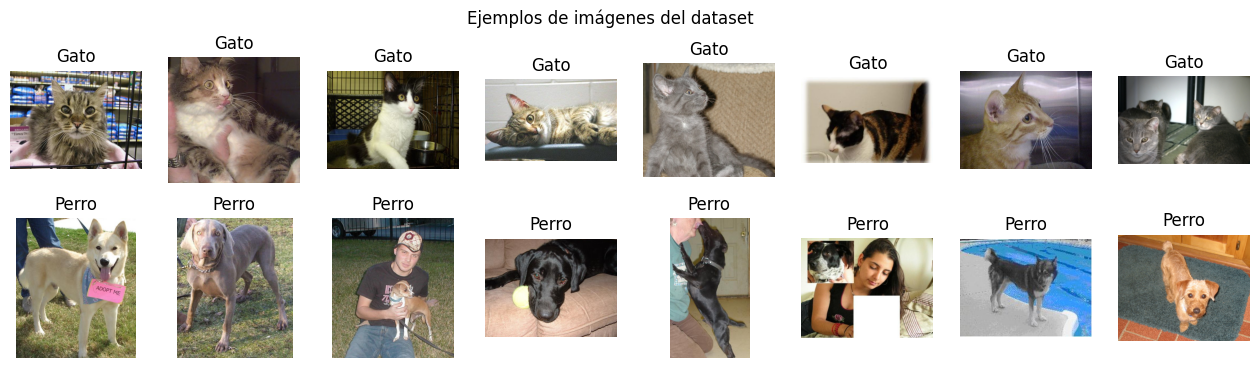

In [ ]:
import matplotlib.pyplot as plt
# Mostrar ejemplos de imágenes (8 gatos y 8 perros)
fig, axs = plt.subplots(2, 8, figsize=(16,4))  # Crear una figura con 2 filas y 8 columnas para subplots
fig.suptitle("Ejemplos de imágenes del dataset")  # Título general para toda la figura

cat_shown = 0   # Contador para imágenes de gatos mostradas
dog_shown = 0   # Contador para imágenes de perros mostradas

# Iterar sobre todas las imágenes válidas junto con sus etiquetas
for img_path, label in zip(valid_image_paths, valid_labels):
    if label == 0 and cat_shown < 8:  # Si es gato y aún no mostramos 8
        ax = axs[0, cat_shown]         # Seleccionar el subplot correspondiente en la primera fila
        img = Image.open(img_path)     # Abrir imagen
        ax.imshow(img)                 # Mostrar imagen en el subplot
        ax.set_title("Gato")           # Título del subplot
        ax.axis("off")                 # Ocultar ejes para mejor visualización
        cat_shown += 1                 # Incrementar contador de gatos mostrados

    elif label == 1 and dog_shown < 8:  # Si es perro y aún no mostramos 8
        ax = axs[1, dog_shown]         # Seleccionar subplot en la segunda fila
        img = Image.open(img_path)     # Abrir imagen
        ax.imshow(img)                 # Mostrar imagen
        ax.set_title("Perro")          # Título
        ax.axis("off")                 # Ocultar ejes
        dog_shown += 1                 # Incrementar contador de perros mostrados

    # Romper el ciclo cuando ya se hayan mostrado 8 gatos y 8 perros
    if cat_shown >= 8 and dog_shown >= 8:
        break

plt.show()  # Mostrar la figura con todos los subplots

__________________________

__________________________

# **PASO 2 Arquitectura de la Red. [Resuelve: MARCOS GALLO]**

# **Consigna de la posta 2:**

- Diseñe una red neuronal convolucional para la clasificación binaria (perros vs gatos)
- La arquitectura debe utilizar exclusivamente capas convolucionales y fully-connected
- Implemente correctamente el forward pass de la red
- Justifique las decisiones de diseño (número de capas, filtros, activaciones, etc.)

## 🧠 Arquitectura de la Red Neuronal Convolucional (CNN) para clasificación de Perros vs Gatos

Se creará una clase que implementa una arquitectura CNN, diseñada  para la tarea de clasificación binaria de imágenes de gatos y perros.

Se buscó un diseño para facilitar el trabajo en equipo, flexible que permite modificar parámetros para experimentar con variantes.

---

### 🔧 Arquitectura General

La clase GatosPerrosCNN hereda de nn.Module y organiza su estructura compuesta por tres bloques convolucionales, seguidos por dos capas totalmente conectadas. Cada bloque realiza:

- Convolución 2D (`Conv2D`)
- Activación no lineal (por defecto: `ReLU`)
- Reducción espacial mediante `MaxPooling`

La parte final densa incluye:

- Aplanado del tensor de activaciones
- Capa fully connected intermedia con activación
- Capa de salida con 1 sola neurona y activación Sigmoid para clasificación binaria (probabilidad entre 0 y 1)




## 🔍 Parámetros configurables del modelo `GatosPerrosCNN`

A continuación, se detallan los parámetros del constructor del modelo `GatosPerrosCNN`, con el objetivo de facilitar su comprensión, experimentación y adaptación por parte de todos los integrantes del equipo.  

---

### 📌 Argumentos del constructor

- **`num_filters: list[int]`**  
  Lista que indica la cantidad de filtros en cada capa convolucional.  
  Por ejemplo: `[16, 32, 64]` define 3 capas con 16, 32 y 64 filtros respectivamente.  
  Esto permite una progresiva extracción de patrones: de bordes simples a formas más complejas.

---

- **`fc_hidden_units: int`**  
  Número de neuronas en la capa `fully connected` intermedia.  
  Une la parte convolucional (extracción de características) con la salida binaria (gato o perro).  
  Comúnmente se usan valores como 64, 128 o 256.

---

- **`input_shape: tuple[int]`**  
  Tamaño esperado de las imágenes de entrada en el formato `(canales, alto, ancho)`, por ejemplo `(3, 128, 128)` para imágenes RGB.  
  Es fundamental para calcular automáticamente el tamaño de entrada a la capa `fully connected`.  
  Aunque las imágenes del dataset se redimensionen a 128x128 por defecto en el preprocesamiento hecho en la Posta 1 (tambien es flexible), incluir este parámetro hace el código más robusto y adaptable.

---

- **`use_dropout: bool`**  
  Si se establece en `True`, agrega una capa `Dropout` antes de la salida.  
  Esto ayuda a **prevenir el sobreajuste** al desactivar aleatoriamente neuronas durante el entrenamiento.  
  Es útil especialmente si se detecta un rendimiento pobre en validación.

---

- **`activation: Callable`**  
  Función de activación utilizada después de cada capa convolucional y `fully connected`.  
  Por defecto se usa `ReLU` (`torch.nn.ReLU()`), por su eficiencia y buen rendimiento promedio.  
  También se podrían probar otras como:
  - `LeakyReLU()`: evita que neuronas se “apaguen” totalmente.
  - `tanh` o `sigmoid`: menos comunes, pero útiles en arquitecturas pequeñas o experimentales.





In [ ]:
# PROMPT:
# "Por favor, crea una clase en Python que defina una red neuronal convolucional para clasificación binaria de imágenes (gatos vs perros).
#La red debe tener 3 capas convolucionales con filtros de tamaño 16, 32 y 64.Cada capa convolucional debe estar seguida de una capa de max pooling.
#Incluye una capa fully connected final con una salida de un valor entre 0 y 1 usando sigmoid. Incluye opciones para usar dropout y una función de
#activación configurable, por ejemplo ReLU.La clase debe calcular automáticamente el tamaño de la entrada a las capas fully connected.
#Define un método forward para pasar los datos a través de la red."


# Importa librerías necesarias
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatosPerrosCNN(nn.Module):
    def __init__(self, num_filters=[16, 32, 64], fc_hidden_units=128, input_shape=(3, 128, 128),
                 use_dropout=False, activation=F.relu):
        super(GatosPerrosCNN, self).__init__()

        self.activation = activation
        self.use_dropout = use_dropout

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=num_filters[0], kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Cálculo del tamaño de entrada a FC
        self._calculate_flatten_dim(input_shape)

        # Capas fully-connected
        self.fc1 = nn.Linear(self.flatten_dim, fc_hidden_units)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc_hidden_units, 1)

    def _calculate_flatten_dim(self, input_shape):
        c, h, w = input_shape
        dummy_input = torch.zeros(1, c, h, w)
        x = self.pool3(self.activation(self.conv3(
            self.pool2(self.activation(self.conv2(
                self.pool1(self.activation(self.conv1(dummy_input)))
            )))
        )))
        self.flatten_dim = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


### 🔍 Cálculo automático del tamaño de entrada a la capa fully connected



De esta manera lo que se evita es tener errores cuando se cambia el tamaño de entrada o se modifican las capas convolucionales. La característica principal es que **el modelo calcula automáticamente el tamaño del vector que ingresa a la capa fully connected intermedia (fc1)**. Para ello, se pasa un tensor "dummy" de ceros a través de todas las capas convolucionales y de pooling, sin necesidad de calcular manualmente la reducción de tamaño producida por las capas de pooling.

Por ejemplo:


`dummy_input = torch.zeros(1, c, h, w)`  
`x = ...` # pasar dummy_input por las capas convolucionales y pooling  
`self.flatten_dim = x.view(1, -1).shape[1]`  

 ### ⏩ Explicación del método `forward`

El método `forward` define cómo los datos de entrada (`x`) pasan a través de la red neuronal en cada paso. Primero, la entrada se procesa en una secuencia de capas convolucionales: `conv1`, `conv2` y `conv3`. Después de cada convolución, se aplica una función de activación (`self.activation`) para introducir no linealidad, seguida de una capa de pooling (`pool1`, `pool2`, `pool3`) que reduce las dimensiones espaciales de las imágenes, ayudando a extraer características de diferentes niveles de abstracción.

Luego, la salida de la última capa de pooling se aplana con `x.view(x.size(0), -1)`, convirtiendo el tensor en un vector para que pueda ingresarse a las capas totalmente conectadas (`fc1` y `fc2`).

Antes de la última capa, se aplica nuevamente la función de activación, y, si `use_dropout` está habilitado, se activa.

El parámetro `use_dropout` controla si se debe aplicar **regularización** por medio de `Dropout`, una técnica que reduce el sobreajuste al "apagar" aleatoriamente algunas neuronas durante el entrenamiento.

Si `use_dropout=True`, el modelo aplicará una capa `Dropout(0.5)` justo después de la activación de la capa fully connected intermedia. Esta opción es útil cuando el modelo memoriza el entrenamiento pero falla en generalizar bien en validación.

Finalmente, la salida pasa por la capa `fc2` y se aplica la función `sigmoid` para producir una probabilidad de clasificación binaria (perro vs gato).



***Uso recomendado:***


---


Esta clase permite ser fácilmente modificada para comparar variantes de arquitectura:
  - Cambiar número de capas o filtros
  - Probar otras funciones de activación
  - Añadir Dropout
  - Ajustar el tamaño de imágenes de entrada



🔍 Verificación inicial de la red: instanciación y prueba con input ficticio.

Antes de entrenar una red neuronal convolucional, es fundamental verificar que la arquitectura esté correctamente implementada. Es lo que sigue en los siguientes pasos:

✅ 1. Instanciación del modelo

In [ ]:
model = GatosPerrosCNN(input_shape=(3, 128, 128))
print(model)


GatosPerrosCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)




Quí se crea una instancia de la clase GatosPerrosCNN, especificando que las imágenes de entrada tienen 3 canales (RGB) y tamaño 128×128 píxeles.

Este paso permite asegurarse de que los tamaños de entrada y salida entre capas están bien conectados. El `print(model)` muestra toda la arquitectura del modelo con sus capas, canales y dimensiones, lo que facilita la revisión en equipo o individual antes del entrenamiento.

🧪 2. Prueba con input "dummy" (aleatorio)

In [ ]:
dummy_input = torch.randn(1, 3, 128, 128)
output_dummy = model(dummy_input)
print(output_dummy)


tensor([[0.5075]], grad_fn=<SigmoidBackward0>)


Primero se crea un tensor ficticio con forma (1, 3, 128, 128) (una imagen RGB de prueba). Luego se lo pasa por el modelo y se imprime la salida.

Este paso verifica el forward pass completo: se comprueba que la red acepta correctamente la entrada y devuelve una salida coherente. Dado que se trata de un problema de clasificación binaria, la salida debe ser un tensor de forma (1, 1) con valores entre 0 y 1 gracias a la activación sigmoid en la última capa.

✅ Esta prueba detecta errores comunes como dimensiones incompatibles o errores de tipo, y permite trabajar con seguridad en la siguiente etapa de entrenamiento.

📊 Visualización de una imagen dummy y su predicción

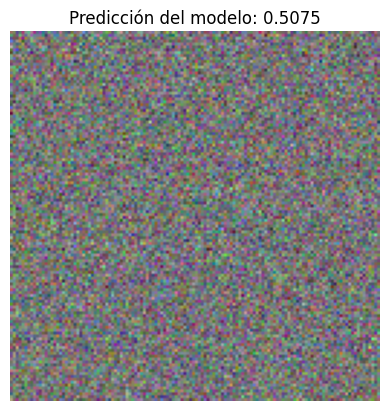

In [ ]:
#Prompt: "Dame un ejemplo de código para visualizar una imagen dummy y su predicción"

# Librerias necesarias
import matplotlib.pyplot as plt
import numpy as np

# Convertir imagen dummy a formato visualizable
imagen = dummy_input[0].permute(1, 2, 0).detach().numpy()
plt.imshow((imagen - imagen.min()) / (imagen.max() - imagen.min()))
plt.title(f"Predicción del modelo: {output_dummy.item():.4f}")
plt.axis('off')
plt.show()


Qué hace este paso?

`dummy_input[0]`: extrae la primera imagen del batch.

`.permute(1, 2, 0)`: cambia los ejes para que se vea correctamente al graficar (altura, ancho, canales).

`.detach().numpy()`: lo transforma en un array de NumPy para poder visualizarlo.

`(imagen - imagen.min()) / (imagen.max() - imagen.min())`: normaliza los valores al rango [0, 1].


---



📌 ¿Qué muestra el gráfico?

Una imagen completamente aleatoria (no es una muestra real del dataset). En el título del gráfico se muestra la salida del modelo.Ejemplo: Predicción del modelo: "valor entre 0 y 1", lo cual puede interpretarse como la probabilidad de que la imagen sea de un perro (1) o un gato (0).

🧩 Esta verificación cumple un rol clave como validación estructural del modelo antes del entrenamiento. Aunque la predicción no tiene valor real aún (porque el modelo no ha sido entrenado), asegura que:

- La arquitectura es funcional.

- El forward pass se ejecuta sin errores.

- Las dimensiones de entrada y salida son correctas.

- Se puede visualizar la salida de forma interpretable.

Este tipo de pruebas se toma como una buena práctica antes de configurar los hiperparámetros y ejecutar el entrenamiento completo.



***Referencias utilizadas:***

---
- Prompt chatgpt

a)   Por favor, crea una clase en Python que defina una red neuronal convolucional para clasificación binaria de imágenes (gatos vs perros).
La red debe tener 3 capas convolucionales con filtros de tamaño 16, 32 y 64.Cada capa convolucional debe estar seguida de una capa de max pooling.
Incluye una capa fully connected final con una salida de un valor entre 0 y 1 usando sigmoid. Incluye opciones para usar dropout y una función de
activación configurable, por ejemplo ReLU.La clase debe calcular automáticamente el tamaño de la entrada a las capas fully connected.
Define un método forward para pasar los datos a través de la red."

b)   Dime puntos a tener en cuenta para lograr una estructura de codigo modular y flexible para un proyecto en equipo con consignas por "postas".

c)   Dame un ejemplo de código para visualizar una imagen dummy y su predicción.

- Bibliografía de la materia







__________________________

___________________________

# **PASO 3 Entrenamiento. [Resuelve: CARLOS E. LEIVA]**

- 3.1 Configure los hiperparámetros del entrenamiento (learning rate, batch size, número de épocas, etc.)

- 3.2 Seleccione una función de pérdida y un optimizador adecuados

- .3.3 Implemente el bucle de entrenamiento completo

- 3.4 Registre las métricas de entrenamiento y validación por época (precisión, recall, F1-score, etc.)

- 3.5 Implemente early stopping basado en el rendimiento de validación

## **3.1. Configurar Hiperparámetros**
En esta sección definimos los hiperparámetros fundamentales para el entrenamiento de la red neuronal. Estos parámetros controlan aspectos clave del proceso de optimización y afectan directamente el desempeño del modelo:

- **Tasa de aprendizaje (learning_rate):** Indica qué tan grande es el paso que da el optimizador en cada actualización de pesos. Un valor demasiado alto puede hacer que el entrenamiento no converja, mientras que uno muy bajo puede hacer que el entrenamiento sea muy lento.
- **Tamaño del batch (batch_size):** Define la cantidad de muestras que se procesan antes de actualizar los pesos del modelo. Un batch pequeño puede hacer el entrenamiento más ruidoso pero puede generalizar mejor, mientras que un batch grande aprovecha mejor la paralelización.
- **Número de épocas (num_epochs):** Cantidad de veces que el modelo recorrerá todo el dataset de entrenamiento. Más épocas pueden mejorar el aprendizaje, pero también pueden provocar sobreajuste si es excesivo.

Estos parámetros se eligen con base en la experiencia, la capacidad del hardware y las características del dataset, y pueden ajustarse posteriormente para mejorar el rendimiento.


In [ ]:
# Hiperparámetros
learning_rate = 0.001
batch_size = 32
num_epochs = 20

## **3.2. Seleccionar función de pérdida y optimizador**

En el Paso 2 definimos el modelo `GatosPerrosCNN`, que termina con una capa de salida con activación **sigmoide** para obtener una probabilidad entre 0 y 1.

Para entrenar un modelo de clasificación binaria, es clave elegir la función de pérdida adecuada según la salida del modelo:

- Si el modelo **ya aplica sigmoide** en la última capa (como `GatosPerrosCNN` del Paso 2), se debe usar **`BCELoss`**, que espera probabilidades como entrada.

- Si prefieres usar una función de pérdida más estable numéricamente, puedes optar por **`BCEWithLogitsLoss`**, pero en ese caso debes **eliminar la sigmoide en el modelo** y entregar directamente los logits sin transformar. Esta función combina internamente la sigmoide y la pérdida.

Como optimizador, utilizamos **Adam**, que ajusta el aprendizaje para cada parámetro y suele ser eficiente para redes convolucionales.


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Modelo previamente definido: model = GatosPerrosCNN(...)
model = GatosPerrosCNN()

# Función de pérdida para clasificación binaria
criterion = nn.BCELoss()  # o nn.BCEWithLogitsLoss() si la salida no pasa por sigmoid

# Optimizador Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## **3.4. Registro de métricas de entrenamiento y validación por época**

En este bloque de código implementamos el ciclo completo de entrenamiento y validación para cada época, incluyendo el cálculo y registro de métricas clave para evaluar el desempeño del modelo.

### Detalles importantes:

- **Fijamos una semilla para reproducibilidad** usando `set_seed()`, asegurando que los resultados sean consistentes entre ejecuciones.
- **Configuramos el dispositivo** para aprovechar GPU si está disponible, acelerando el entrenamiento.
- Durante el **entrenamiento** (`model.train()`):
  - Recorremos los batches del conjunto de entrenamiento.
  - Movemos datos y etiquetas al dispositivo.
  - Reseteamos gradientes (`optimizer.zero_grad()`).
  - Calculamos la salida del modelo y la pérdida.
  - Retropropagamos el error (`loss.backward()`) y actualizamos los pesos (`optimizer.step()`).
  - Acumulamos la pérdida total y guardamos las predicciones y etiquetas reales para calcular métricas al final de la época.
- Calculamos las **métricas de entrenamiento** al finalizar la época:
  - Pérdida promedio
  - Precisión (Precision)
  - Sensibilidad o recall (Recall)
  - F1-score, que combina precisión y recall en una sola medida balanceada.
- Durante la **validación** (`model.eval()`):
  - Desactivamos el cálculo de gradientes con `torch.no_grad()` para ahorrar memoria y cómputo.
  - Repetimos un proceso similar al entrenamiento pero sin optimización, solo evaluación.
  - Calculamos las mismas métricas para medir la capacidad del modelo en datos no vistos durante el entrenamiento.
- Finalmente, imprimimos un resumen formateado con el tiempo transcurrido por época y todas las métricas calculadas.

### Métricas clave:

- **Precisión (Precision):** proporción de predicciones positivas correctas entre todas las predicciones positivas.
- **Recall:** proporción de verdaderos positivos detectados entre todos los positivos reales.
- **F1-score:** media armónica de precisión y recall, útil para datasets desbalanceados.

Este registro por época permite monitorear el aprendizaje del modelo y detectar posibles problemas como overfitting (cuando la validación empeora mientras que el entrenamiento mejora).


In [ ]:
import time
import random
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Fijamos la semilla para reproducibilidad ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# --- Configuración del dispositivo ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Loop principal de entrenamiento ---
for epoch in range(num_epochs):
    start_time = time.time()

    # ===== ENTRENAMIENTO =====
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    # Iteramos sobre los batches del conjunto de entrenamiento
    for inputs, labels in train_loader:
        # Movemos los datos al dispositivo (GPU o CPU)
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()          # Reiniciamos los gradientes
        outputs = model(inputs).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()               # Backpropagation
        optimizer.step()              # Actualizamos los pesos

        train_loss += loss.item() * inputs.size(0)  # Acumulamos la pérdida
        preds = (outputs > 0.5).int()               # Predicciones binarias (umbral 0.5)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Métricas de entrenamiento por época
    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_precision = precision_score(train_labels, train_preds)
    epoch_train_recall = recall_score(train_labels, train_preds)
    epoch_train_f1 = f1_score(train_labels, train_preds)

    # ===== VALIDACIÓN =====
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():  # Desactivamos el cálculo de gradientes
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).int()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Métricas de validación por época
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_precision = precision_score(val_labels, val_preds)
    epoch_val_recall = recall_score(val_labels, val_preds)
    epoch_val_f1 = f1_score(val_labels, val_preds)

    end_time = time.time()
    elapsed = end_time - start_time

    # ===== PRINT FORMATEADO POR ÉPOCA =====
    print(f"🧠 Epoch {epoch+1}/{num_epochs} - ⏱️ Tiempo: {elapsed:.2f}s")
    print(f"   🔹 Train -> Loss: {epoch_train_loss:.2f}, Precision: {epoch_train_precision:.2f}, Recall: {epoch_train_recall:.2f}, F1: {epoch_train_f1:.2f}")
    print(f"   🔸 Valid -> Loss: {epoch_val_loss:.2f}, Precision: {epoch_val_precision:.2f}, Recall: {epoch_val_recall:.2f}, F1: {epoch_val_f1:.2f}\n")

🧠 Epoch 1/20 - ⏱️ Tiempo: 66.89s
   🔹 Train -> Loss: 0.61, Precision: 0.66, Recall: 0.66, F1: 0.66
   🔸 Valid -> Loss: 0.54, Precision: 0.76, Recall: 0.69, F1: 0.72



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 2/20 - ⏱️ Tiempo: 68.27s
   🔹 Train -> Loss: 0.51, Precision: 0.75, Recall: 0.74, F1: 0.75
   🔸 Valid -> Loss: 0.48, Precision: 0.82, Recall: 0.69, F1: 0.75



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 3/20 - ⏱️ Tiempo: 67.77s
   🔹 Train -> Loss: 0.45, Precision: 0.79, Recall: 0.78, F1: 0.79
   🔸 Valid -> Loss: 0.44, Precision: 0.75, Recall: 0.90, F1: 0.82



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 4/20 - ⏱️ Tiempo: 68.20s
   🔹 Train -> Loss: 0.41, Precision: 0.81, Recall: 0.81, F1: 0.81
   🔸 Valid -> Loss: 0.38, Precision: 0.82, Recall: 0.85, F1: 0.84



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 5/20 - ⏱️ Tiempo: 67.11s
   🔹 Train -> Loss: 0.39, Precision: 0.82, Recall: 0.83, F1: 0.82
   🔸 Valid -> Loss: 0.37, Precision: 0.79, Recall: 0.91, F1: 0.84



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 6/20 - ⏱️ Tiempo: 67.20s
   🔹 Train -> Loss: 0.36, Precision: 0.84, Recall: 0.84, F1: 0.84
   🔸 Valid -> Loss: 0.35, Precision: 0.84, Recall: 0.84, F1: 0.84



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 7/20 - ⏱️ Tiempo: 68.03s
   🔹 Train -> Loss: 0.34, Precision: 0.85, Recall: 0.86, F1: 0.85
   🔸 Valid -> Loss: 0.34, Precision: 0.83, Recall: 0.87, F1: 0.85



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 8/20 - ⏱️ Tiempo: 68.38s
   🔹 Train -> Loss: 0.33, Precision: 0.85, Recall: 0.86, F1: 0.86
   🔸 Valid -> Loss: 0.35, Precision: 0.88, Recall: 0.80, F1: 0.84



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 9/20 - ⏱️ Tiempo: 66.84s
   🔹 Train -> Loss: 0.31, Precision: 0.86, Recall: 0.87, F1: 0.87
   🔸 Valid -> Loss: 0.33, Precision: 0.88, Recall: 0.83, F1: 0.86



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 10/20 - ⏱️ Tiempo: 67.03s
   🔹 Train -> Loss: 0.29, Precision: 0.87, Recall: 0.88, F1: 0.87
   🔸 Valid -> Loss: 0.31, Precision: 0.86, Recall: 0.88, F1: 0.87



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 11/20 - ⏱️ Tiempo: 67.10s
   🔹 Train -> Loss: 0.27, Precision: 0.88, Recall: 0.89, F1: 0.88
   🔸 Valid -> Loss: 0.30, Precision: 0.87, Recall: 0.88, F1: 0.88



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 12/20 - ⏱️ Tiempo: 69.44s
   🔹 Train -> Loss: 0.26, Precision: 0.88, Recall: 0.89, F1: 0.89
   🔸 Valid -> Loss: 0.30, Precision: 0.89, Recall: 0.85, F1: 0.87



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 13/20 - ⏱️ Tiempo: 67.54s
   🔹 Train -> Loss: 0.24, Precision: 0.89, Recall: 0.90, F1: 0.90
   🔸 Valid -> Loss: 0.28, Precision: 0.87, Recall: 0.89, F1: 0.88



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 14/20 - ⏱️ Tiempo: 67.18s
   🔹 Train -> Loss: 0.24, Precision: 0.89, Recall: 0.90, F1: 0.90
   🔸 Valid -> Loss: 0.32, Precision: 0.90, Recall: 0.83, F1: 0.87



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 15/20 - ⏱️ Tiempo: 66.52s
   🔹 Train -> Loss: 0.22, Precision: 0.91, Recall: 0.91, F1: 0.91
   🔸 Valid -> Loss: 0.30, Precision: 0.88, Recall: 0.87, F1: 0.87



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 16/20 - ⏱️ Tiempo: 67.89s
   🔹 Train -> Loss: 0.21, Precision: 0.91, Recall: 0.92, F1: 0.91
   🔸 Valid -> Loss: 0.29, Precision: 0.91, Recall: 0.86, F1: 0.88



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 17/20 - ⏱️ Tiempo: 67.54s
   🔹 Train -> Loss: 0.21, Precision: 0.91, Recall: 0.92, F1: 0.91
   🔸 Valid -> Loss: 0.30, Precision: 0.89, Recall: 0.87, F1: 0.88



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 18/20 - ⏱️ Tiempo: 66.58s
   🔹 Train -> Loss: 0.20, Precision: 0.92, Recall: 0.92, F1: 0.92
   🔸 Valid -> Loss: 0.31, Precision: 0.85, Recall: 0.91, F1: 0.88



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 19/20 - ⏱️ Tiempo: 66.96s
   🔹 Train -> Loss: 0.19, Precision: 0.92, Recall: 0.93, F1: 0.92
   🔸 Valid -> Loss: 0.30, Precision: 0.88, Recall: 0.90, F1: 0.89



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 20/20 - ⏱️ Tiempo: 68.41s
   🔹 Train -> Loss: 0.18, Precision: 0.92, Recall: 0.93, F1: 0.93
   🔸 Valid -> Loss: 0.28, Precision: 0.87, Recall: 0.90, F1: 0.89



--------------
## 3.5 Implementación de Early Stopping basado en rendimiento de validación

### ¿Qué es Early Stopping?

Early stopping es una técnica que detiene el entrenamiento de un modelo cuando la métrica de evaluación en el conjunto de validación deja de mejorar después de un número determinado de épocas (llamado *patiencia*). Esto ayuda a prevenir el sobreajuste y a optimizar el uso de recursos computacionales.

---

### Funcionamiento en el código

1. **Variable `best_f1`:**  
   Guarda el mejor valor de F1-score observado en el conjunto de validación. Se inicializa en 0.

2. **Parámetro `patience`:**  
   Número de épocas consecutivas sin mejora permitidas antes de detener el entrenamiento (en este caso, 3).

3. **Durante cada época de entrenamiento:**

   - Se calcula el F1-score en validación (`epoch_val_f1`).
   - Si `epoch_val_f1` es mejor que `best_f1`:  
     - Se actualiza `best_f1` con el nuevo valor.  
     - Se guarda el estado actual del modelo (`best_model.pth`).  
     - Se reinicia el contador de épocas sin mejora (`counter = 0`).
   - Si no hay mejora:  
     - Se incrementa el contador (`counter += 1`).

4. **Condición de parada:**  
   Si `counter` alcanza el valor de `patience`, el entrenamiento se detiene anticipadamente (`break`).

5. **Al final:**  
   Se carga el mejor modelo guardado para usarlo en evaluaciones o inferencia posteriores.

### Beneficios

- Evita sobreentrenar el modelo más allá del punto óptimo.  
- Reduce tiempo y recursos de entrenamiento.  
- Garantiza que se utilice el modelo con mejor rendimiento en validación.




In [ ]:
import time
import random
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Fijamos la semilla para reproducibilidad ---
# Esto asegura que los resultados sean iguales cada vez que se ejecuta el script
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# --- Configuración del dispositivo (GPU si está disponible) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Parámetros de Early Stopping ---
best_f1 = 0.0              # Mejor F1 observado hasta el momento
patience = 3               # Nº de épocas sin mejora antes de frenar
counter = 0                # Cuántas épocas seguidas no mejoró
best_model_path = "best_model.pth"  # Donde se guarda el mejor modelo
best_epoch = 0             # Época donde se logró el mejor F1

# --- Ciclo principal de entrenamiento ---
for epoch in range(num_epochs):
    start_time = time.time()

    # --- Entrenamiento ---
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for inputs, labels in train_loader:
        # Pasamos datos a dispositivo
        inputs, labels = inputs.to(device), labels.float().to(device)

        # Paso de forward + backward
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Acumulamos métricas
        train_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).int()
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Cálculo de métricas de entrenamiento
    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_precision = precision_score(train_labels, train_preds)
    epoch_train_recall = recall_score(train_labels, train_preds)
    epoch_train_f1 = f1_score(train_labels, train_preds)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).int()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Cálculo de métricas de validación
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_precision = precision_score(val_labels, val_preds)
    epoch_val_recall = recall_score(val_labels, val_preds)
    epoch_val_f1 = f1_score(val_labels, val_preds)

    end_time = time.time()
    elapsed = end_time - start_time

    # --- Impresión de métricas por época ---
    print(f"🧠 Epoch {epoch+1}/{num_epochs} - ⏱️ Tiempo: {elapsed:.2f}s")
    print(f"   🔹 Train -> Loss: {epoch_train_loss:.2f}, Precision: {epoch_train_precision:.2f}, Recall: {epoch_train_recall:.2f}, F1: {epoch_train_f1:.2f}")
    print(f"   🔸 Valid -> Loss: {epoch_val_loss:.2f}, Precision: {epoch_val_precision:.2f}, Recall: {epoch_val_recall:.2f}, F1: {epoch_val_f1:.2f}")

    # --- Lógica de Early Stopping ---
    if epoch_val_f1 > best_f1:
        best_f1 = epoch_val_f1
        best_epoch = epoch + 1
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Mejor F1 en validación: {best_f1:.2f} → Modelo guardado.\n")
    else:
        counter += 1
        print(f"⏸️ Sin mejora en F1 ({counter}/{patience})\n")
        if counter >= patience:
            print("⛔ Early stopping activado.")
            break

# --- Restaurar el mejor modelo antes de evaluar o usar ---
model.load_state_dict(torch.load(best_model_path))
print(f"✅ Modelo restaurado desde la epoch {best_epoch} con mejor F1: {best_f1:.2f}")

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 1/20 - ⏱️ Tiempo: 69.28s
   🔹 Train -> Loss: 0.17, Precision: 0.93, Recall: 0.94, F1: 0.93
   🔸 Valid -> Loss: 0.31, Precision: 0.89, Recall: 0.87, F1: 0.88
✅ Mejor F1 en validación: 0.88 → Modelo guardado.



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 2/20 - ⏱️ Tiempo: 66.99s
   🔹 Train -> Loss: 0.17, Precision: 0.93, Recall: 0.94, F1: 0.93
   🔸 Valid -> Loss: 0.32, Precision: 0.90, Recall: 0.87, F1: 0.89
✅ Mejor F1 en validación: 0.89 → Modelo guardado.



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 3/20 - ⏱️ Tiempo: 66.68s
   🔹 Train -> Loss: 0.16, Precision: 0.93, Recall: 0.94, F1: 0.94
   🔸 Valid -> Loss: 0.32, Precision: 0.86, Recall: 0.92, F1: 0.89
⏸️ Sin mejora en F1 (1/3)



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 4/20 - ⏱️ Tiempo: 67.01s
   🔹 Train -> Loss: 0.15, Precision: 0.94, Recall: 0.94, F1: 0.94
   🔸 Valid -> Loss: 0.34, Precision: 0.86, Recall: 0.90, F1: 0.88
⏸️ Sin mejora en F1 (2/3)



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 5/20 - ⏱️ Tiempo: 67.68s
   🔹 Train -> Loss: 0.15, Precision: 0.94, Recall: 0.94, F1: 0.94
   🔸 Valid -> Loss: 0.36, Precision: 0.86, Recall: 0.92, F1: 0.89
✅ Mejor F1 en validación: 0.89 → Modelo guardado.



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 6/20 - ⏱️ Tiempo: 67.85s
   🔹 Train -> Loss: 0.15, Precision: 0.94, Recall: 0.94, F1: 0.94
   🔸 Valid -> Loss: 0.32, Precision: 0.91, Recall: 0.85, F1: 0.88
⏸️ Sin mejora en F1 (1/3)



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 7/20 - ⏱️ Tiempo: 67.76s
   🔹 Train -> Loss: 0.14, Precision: 0.94, Recall: 0.95, F1: 0.95
   🔸 Valid -> Loss: 0.32, Precision: 0.87, Recall: 0.91, F1: 0.89
⏸️ Sin mejora en F1 (2/3)



/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


🧠 Epoch 8/20 - ⏱️ Tiempo: 66.81s
   🔹 Train -> Loss: 0.13, Precision: 0.94, Recall: 0.95, F1: 0.95
   🔸 Valid -> Loss: 0.31, Precision: 0.89, Recall: 0.90, F1: 0.89
✅ Mejor F1 en validación: 0.89 → Modelo guardado.



## Conclusión
El modelo muestra una mejora consistente en las métricas de validación durante las primeras épocas, especialmente en F1-score, que alcanza un máximo de 0.89. El entrenamiento logra mantener una buena precisión y recall, con pérdidas bajas tanto en entrenamiento como en validación.

Se observa que el early stopping funcionó correctamente, ya que el entrenamiento se detuvo tras detectar varias épocas sin mejora significativa en el F1 de validación, evitando así el sobreajuste. Además, el mejor modelo fue guardado y restaurado exitosamente para su uso posterior.

En resumen, el modelo entrenado es robusto y el procedimiento de early stopping ayuda a optimizar el rendimiento y el tiempo de entrenamiento.

# Referencias

- **Material de clases**  
  Base para la estructura del proyecto, manejo de datasets y entrenamiento con PyTorch.

- **Prompts utilizados con GPT para mejorar el código y obtener sugerencias:**

  - *Descarga y descompresión segura y eficiente:*  
    "Necesito un script en Python que descargue un archivo ZIP desde una URL y lo descomprima, pero que primero verifique si el archivo ya está descargado y la carpeta ya está descomprimida para no repetir el proceso y no ralentizar la ejecución. Que sea simple y con mensajes claros de estado."

  - *Dataset personalizado en PyTorch para imágenes de gatos y perros con transformaciones básicas:*  
    "¿Podés mostrarme cómo implementar un Dataset personalizado con PyTorch para un conjunto de imágenes de gatos y perros, y cómo usarlo con un DataLoader que incluya transformaciones como resize y conversión a tensor?"

  - *Transformaciones recomendadas para dataset de imágenes en PyTorch:*  
    "Estoy trabajando con el dataset de gatos y perros. ¿Qué transformaciones debería aplicar con PyTorch (resize, normalización y data augmentation) para usar en un DataLoader personalizado?"

  - *Control de aleatoriedad para reproducibilidad:*  
    "¿Cómo aplicar una semilla fija para random_split en PyTorch?"

  - *División estratificada del dataset para mantener proporción de clases:*  
    "¿Cuál es la mejor manera de mantener la proporción de clases al dividir un dataset para entrenamiento y validación?"

  - *Detección y filtrado de imágenes corruptas en datasets de imágenes:*  
    "¿Cómo detectar y filtrar imágenes corruptas en un dataset de imágenes en PyTorch?"  
    "¿Cómo validar que las imágenes de un dataset estén en formato RGB y no corruptas antes de usarlas?"

  - *Buenas prácticas para limpieza de datasets de imágenes:*  
    "¿Qué criterios puedo usar para limpiar un dataset de imágenes antes del entrenamiento?"

  - *Configuración de hiperparámetros para entrenamiento en PyTorch:*  
    "¿Cómo configuro correctamente el learning rate, batch size y número de épocas para entrenar un modelo en PyTorch?"

  - *Función de pérdida y optimizador para clasificación binaria:*  
    "¿Cuál es la función de pérdida más adecuada para un problema de clasificación binaria?"

  - *Implementación de early stopping en PyTorch para control de sobreajuste:*  
    "¿Cómo implemento early stopping en PyTorch para detener el entrenamiento cuando la métrica de validación deja de mejorar?"


_____________
______________
_____________